# Analysis

In [6]:
using PythonCall

In [7]:
# using CondaPkg
# CondaPkg.add("xrft")

# CondaPkg.withenv() do
    # run(`python --version`)
# end

In [97]:
using AlgebraOfGraphics,
    CairoMakie
using DataFrames,
    DataFramesMeta,
    CategoricalArrays
using Arrow
using Statistics
import JSON
using LinearAlgebra
using LaTeXStrings
using Latexify
using beforerr

In [12]:
dim = 3
beta = 0.25
theta = 60
eta = 100
dir = "01_oblique_linear_alfven/dim_$(dim)_beta_$(beta)_theta_$(theta)_eta_$(eta)"
try
    cd(dir)
    println("Changed to directory: $(dir)")
catch
end

# load simulation metadata (json)
meta = JSON.parsefile("sim_parameters.json")

Changed to directory: 01_oblique_linear_alfven/dim_3_beta_0.25_theta_60_eta_100


Dict{String, Any} with 45 entries:
  "diag_field"  => true
  "w_pi"        => 13165.5
  "Lz_norm"     => 256
  "dt"          => 0.00655945
  "Lx_norm"     => 4.0
  "m_ion_norm"  => 1836.15
  "nz"          => 512
  "Te"          => 62.0516
  "ny"          => 8
  "wave_number" => 4
  "dz_norm"     => 0.5
  "vA_over_c"   => 0.000727373
  "Lz"          => 5.82939e6
  "nppc"        => 64
  "dz"          => 11385.5
  "k"           => 4.31138e-6
  "grid_kwargs" => Dict{String, Any}("warpx_blocking_factor_y"=>4, "warpx_block…
  "m_ion"       => 1.67262e-27
  "diag_format" => "plotfile"
  ⋮             => ⋮

In [14]:
ext = "arrow"

if meta["diag_format"] == "openpmd"
    field_diag_dir = "diags/diag1"
else
    field_diag_dir = "diags"
end

"diags"

In [43]:
function normalize_df!(df)

    B_fields = names(df, r"B")
    E_field = names(df, r"E")
    j_field = names(df, r"j")

    @transform!(df,
        :time_norm = :time ./ meta["t_ci"],
        :z_norm = :z / meta["d_i"],
    )
    transform!(df,
        B_fields => ByRow(norm ∘ vcat) => :Bmag,
        E_field => ByRow(norm ∘ vcat) => :Emag,
        j_field => ByRow(norm ∘ vcat) => :jmag,
    )
end

normalize_df! (generic function with 1 method)

In [44]:
files = filter(contains(r".*\.arrow"), readdir(field_diag_dir, join=true))
dfs = vcat(files .|> Arrow.Table .|> DataFrame)
df = reduce(vcat,dfs) |> normalize_df!;

In [47]:
B_fields = names(df, r"B")
E_field = names(df, r"E")
j_field = names(df, r"j")

variables = [B_comp_fields; E_field; j_field]

12-element Vector{String}:
 "Bx"
 "By"
 "Bz"
 "Bmag"
 "Ex"
 "Ey"
 "Ez"
 "Emag"
 "jx"
 "jy"
 "jz"
 "jmag"

In [76]:
Pair.(["a", "b"],["b", "d"])

["a", "b"] => ["b", "d"]

In [102]:
# calculate the mean of the data by averaging over "y" and "z"
z_norm_lab = L"z~(d_i)"
time_norm_lab = L"T~(T_{ci})"
ids = [:z_norm, :time_norm]
labs = [z_norm_lab, time_norm_lab]

function get_avg_fields(df, fields; ids=ids)
    @chain df begin
        groupby(ids)
        combine(fields .=> mean, renamecols=false)
        stack(fields, ids)
    end
end

function plot_fields(df, fields; ids=ids, fig_options = (size = (800, 800),))

    temp_df = get_avg_fields(df, fields, ids=ids)
    plt = data(temp_df) * mapping(Pair.(ids, labs)..., :value, row = :variable) * visual(Heatmap)

    draw(plt; figure = fig_options)
end

function plot_fields_time(df, fields; ids=ids, step=1)

    # select subset of the data with step
    gdf = groupby(df, :time)[begin:step:end]
    temp_df = combine(gdf, names(df))

    temp_df = get_avg_fields(temp_df, fields, ids=ids)
    temp_df.time_norm = CategoricalArray(temp_df.time_norm .|> floor)

    height = 100 * length(unique(temp_df.time_norm))
    fig_options = (size = (1200, height),)

    plt = data(temp_df) * mapping(:z_norm => z_norm_lab, :value, color = :variable, row= :time_norm) * visual(Lines)
    draw(plt; figure = fig_options)
end

plot_fields_time (generic function with 1 method)

In [112]:
plot_fields(df, B_fields)
easy_save("B_field")
plot_fields(df, E_field)
easy_save("E_field")
plot_fields(df, j_field)
easy_save("j_field");

┌ Info: Saved figures/B_field
└ @ beforerr /Users/zijin/.julia/dev/beforerr.jl/src/utils/makie.jl:34
┌ Info: Saved figures/E_field
└ @ beforerr /Users/zijin/.julia/dev/beforerr.jl/src/utils/makie.jl:34
┌ Info: Saved figures/j_field
└ @ beforerr /Users/zijin/.julia/dev/beforerr.jl/src/utils/makie.jl:34


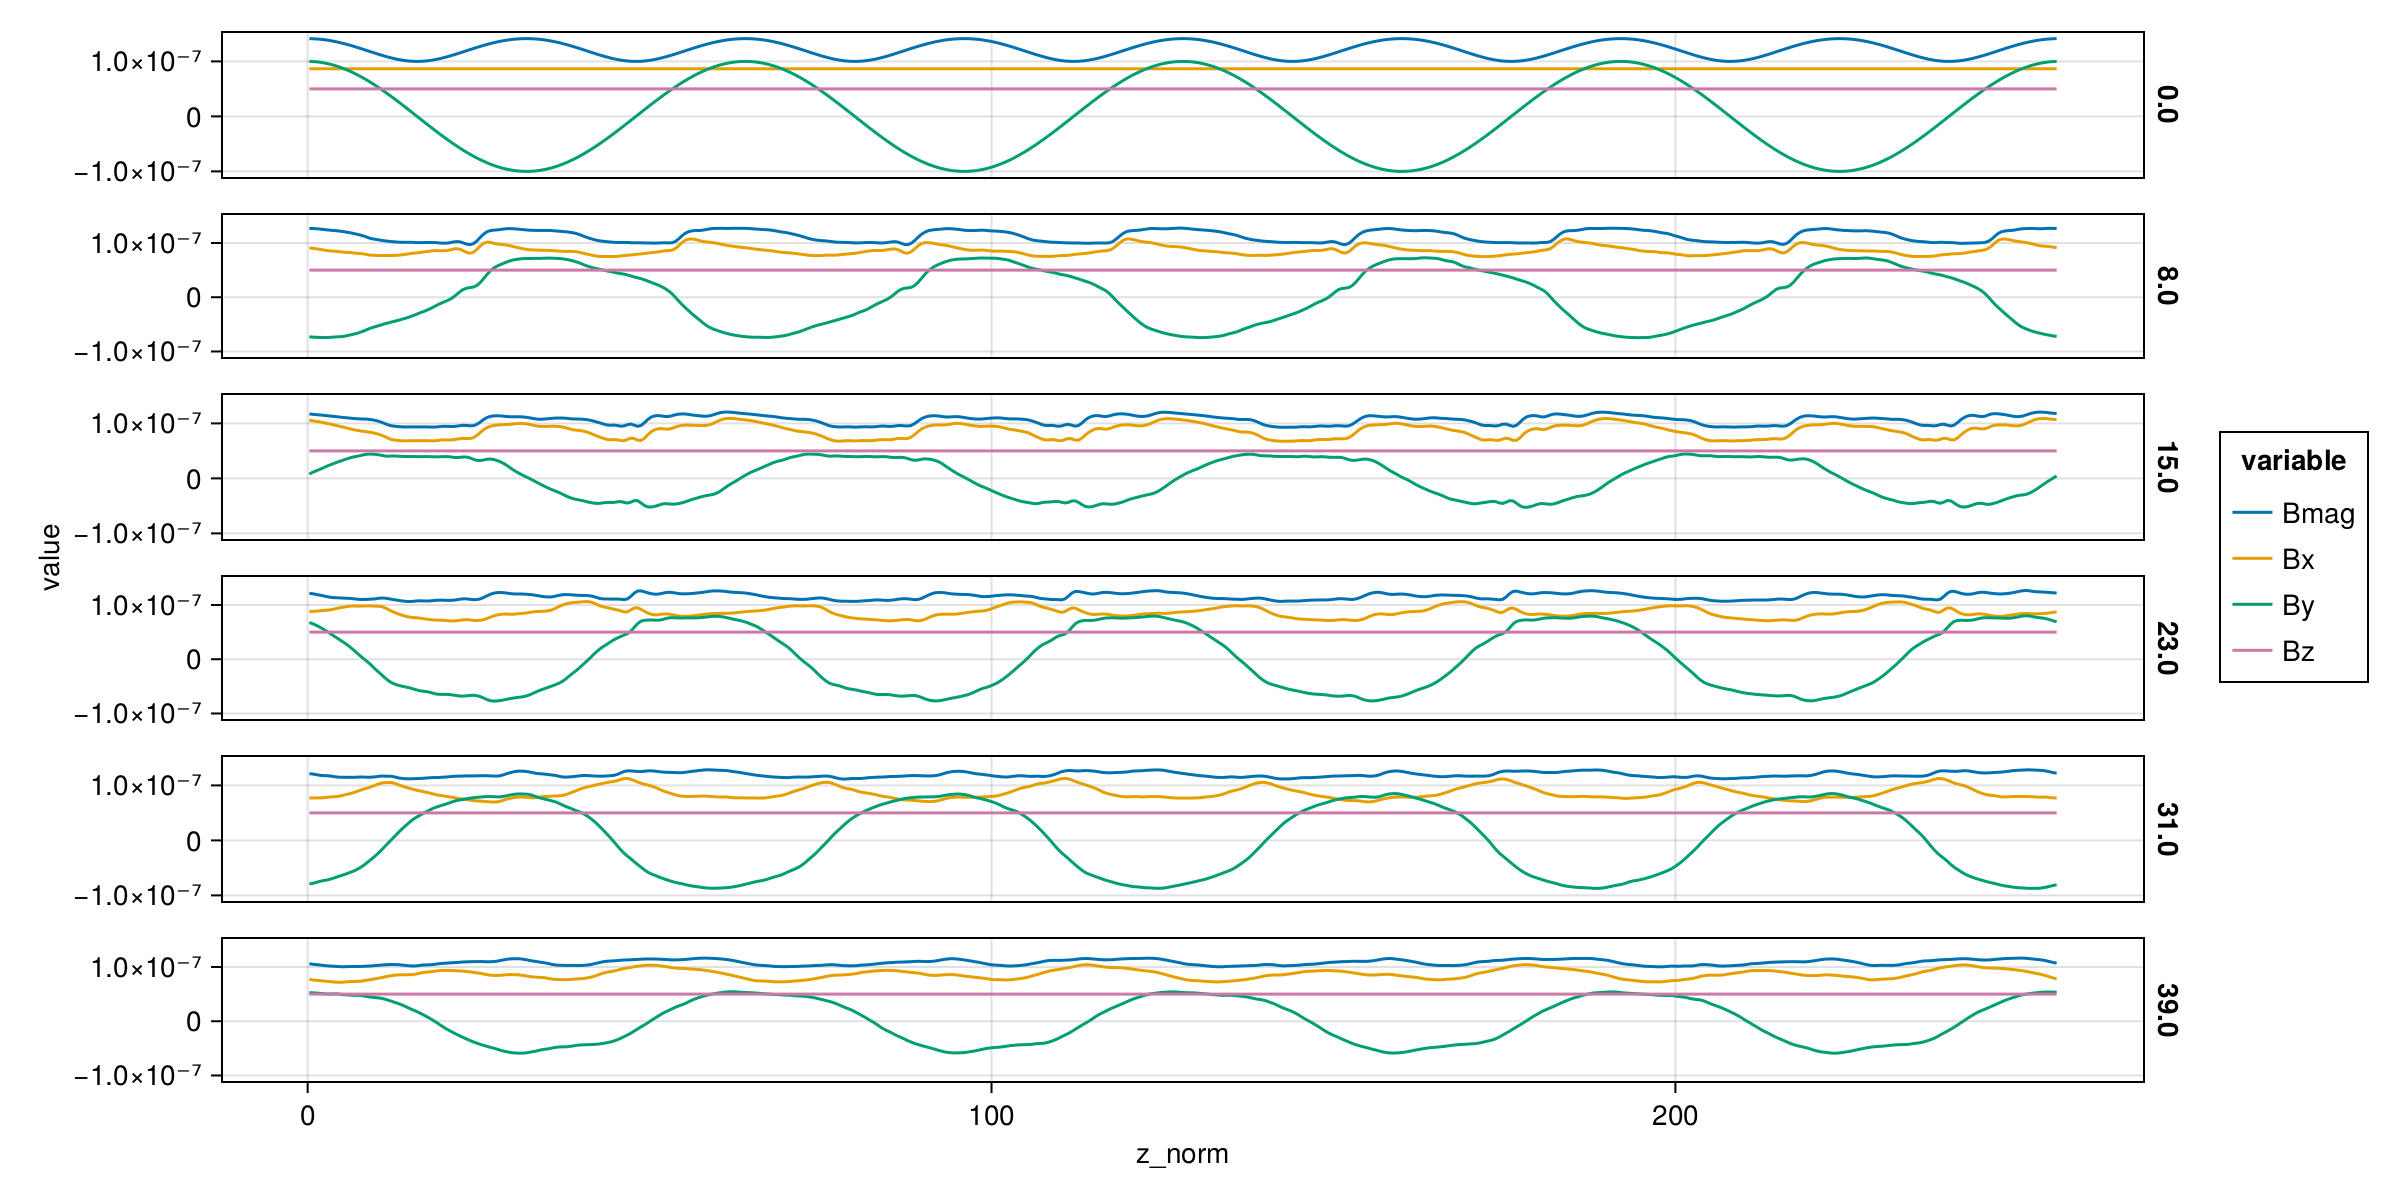

In [59]:
plot_fields_time(df, B_comp_fields; step=8)

In [53]:
function plot_pressure_evolution()
    fp = "part_pressure.arrow"
    df = Arrow.Table(fp) |> DataFrame

    oldnames = ["particle_momentum_x_var", "particle_momentum_y_var", "particle_momentum_z_var"]
    newnames = ["P_xx", "P_yy", "P_zz"]
    rename!(df, oldnames .=> newnames)

    normalize_df!(df)
    stacked_df = stack(df, newnames, ids)
    data(stacked_df) * mapping(ids..., :value, row = :variable => latexify) * visual(Heatmap) |> draw
end

plot_pressure_evolution (generic function with 1 method)

## Fluid fields

In [ ]:
file = "particle.arrow"
path = joinpath(dir, file)
df = path |> Arrow.Table |> DataFrame

In [ ]:
df.z_norm = df.particle_position_z / meta["d_i"]
df.py_norm = df.particle_momentum_y / 1e-25

In [ ]:
plt = data(df) * mapping(:particle_position_z, :time,:particle_momentum_y) * visual(Heatmap)
draw(plt)

### Non-binned particle data

In [ ]:
df.time_norm = CategoricalArray(df.time ./ meta["t_ci"])

In [ ]:
z_norm_edge = 0:1:240
py_norm_edge = -1e3:10:1e3

In [ ]:
datalimits_f = x -> quantile(x, [0.05, 0.95])

In [ ]:
fig_options = (size = (1200, 1000),)

plt = data(df) * mapping(:z_norm, :py_norm, layout=:time_norm) * histogram(datalimits=datalimits_f)
p = draw(plt; figure = fig_options)

## Parameters

In [ ]:
using Pkg
Pkg.add("Symbolics")

In [ ]:
using Symbolics

In [ ]:
@variables t x y μ_0 B ρ c n q m ϵ_0

Alfven_speed = B / sqrt(μ_0 * ρ)

# plasma frequency
ω_p = sqrt(n * q / (m * ϵ_0))
# inertial_length
d_i = c / ω_p

# gryofrequency
ω_c = q * B / m


simplify(ω_c / ω_p)

In [ ]:
ω_c / ω_p